In [1]:
%matplotlib inline

In [2]:
import argparse
import collections
import sqlite3
import sys

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from importlib import reload
import parse_db
reload(parse_db)

<module 'parse_db' from '/Users/jobevers/projects/personal/bowlingscorer/parse_db.py'>

In [4]:
conn = sqlite3.connect('/Users/jobevers/Dropbox/bowling/Backup.db')
conn.row_factory = sqlite3.Row 

In [5]:
parse_db.process_db(conn)

First Ball Average: 8.487179487179487
You've bowled 390 frames
---
Pin Leaves
Pin	1	2
1	13.33%	2.82%
2	15.90%	3.59%
3	16.41%	4.87%
4	17.44%	4.87%
5	14.87%	2.82%
6	19.49%	5.64%
7	15.90%	6.41%
8	6.15%	2.05%
9	9.74%	2.05%
10	22.05%	10.26%
---
Strikes: 110 / 390 => 28.205128%
Spares: 153 / 390 => 39.230769%
Opens: 127 / 390 => 32.564103%
---
Splits: 55 / 280 => 19.642857%
Split-Conversion: 8 / 55 => 14.545455%
---
Non-Splits: 225 / 280 => 80.357143%
Non-Split-Conversion: 145 / 225 => 64.444444%
---
Single Pin Leaves: 106 / 225 => 0.4711111111111111
Single Pin Conversion: 70 / 106 =>  0.660377358490566
For pin 10: 15 / 26 => 57.7%
For pin 7: 8 / 15 => 53.3%
For pin 6: 14 / 19 => 73.7%
For pin 3: 8 / 12 => 66.7%
For pin 2: 1 / 4 => 25.0%
For pin 9: 5 / 7 => 71.4%
For pin 8: 1 / 3 => 33.3%
For pin 4: 8 / 10 => 80.0%
For pin 5: 9 / 9 => 100.0%
For pin 1: 1 / 1 => 100.0%
SINGLE PIN CONVERSION IS THE EASIEST WAY TO IMPROVE YOUR AVERAGE!
IF THIS WAS 100%, YOUR AVERAGE WOULD INCREASE BY: 8.7573964

In [6]:
# ['ID', 'EventID', 'Game', 'Score']
rows = conn.execute('select * from T_Score').fetchall()
totals = pd.DataFrame(rows, columns=rows[0].keys())

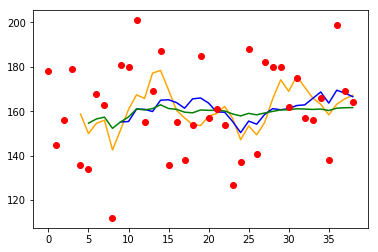

In [7]:
fig, ax = plt.subplots()
scores = totals['Score']
scores.rolling(5).mean().plot(ax=ax, label='5gm Avg', color="orange")
scores.rolling(10).mean().plot(ax=ax, label='10gm Avg', color="blue")
scores.expanding(6).mean().plot(ax=ax, label='League Avg', color="green")
scores.plot(ax=ax, marker='o', linestyle='', color="red");
#ax.legend()

In [8]:
# ['ID', 'Game', 'Frame', 'T1', 'T2', 'Foul1', 'Foul2', 'Split', 'Renzoku', 'Pin']
rows = conn.execute('select * from T_Games where Frame <= 10').fetchall()
frames_df = pd.DataFrame(rows, columns=rows[0].keys())
fba = frames_df['T1'].mean()
print(f'First Ball Average: {fba}')

pin_leaves = []
for row in rows:
    pins = row['Pin']
    pin_leaves.append(parse_db.parse_pins(pins))
n = len(pin_leaves)

First Ball Average: 8.487179487179487


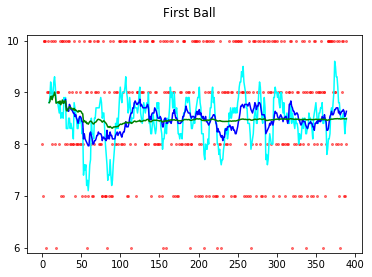

In [9]:
fig, ax = plt.subplots()
scores = frames_df['T1']
scores.plot(ax=ax, marker='o', linestyle='', markersize=2, color="red", alpha=.5);
scores.rolling(10).mean().plot(ax=ax, label='10fm Avg', color="cyan")
scores.rolling(30).mean().plot(ax=ax, label='30fm Avg', color="blue")
scores.expanding(10).mean().plot(ax=ax, label='League Avg', color="green")
fig.suptitle('First Ball')
ax.set_ylim(5.9, 10.1)
ax.set_yticks((6, 7, 8, 9, 10));

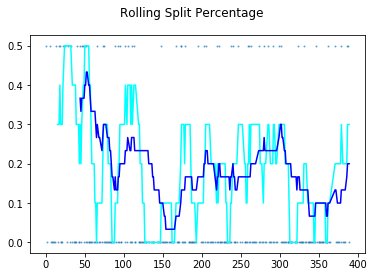

In [10]:
is_not_strike = frames_df[frames_df['T1'] < 10]
is_split = (is_not_strike['Split'] == 1).astype(int)
is_split.rolling(10).mean().plot(color="cyan")
ax = is_split.rolling(30).mean().plot(color="blue")
ax.scatter(is_split.index, is_split*.5, marker='.', alpha=.5, s=5)
ax.figure.suptitle('Rolling Split Percentage');

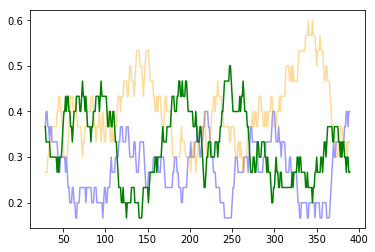

In [13]:
# TODO: break out the spare percentage between splits and non-split spares
#       because an increase in spare percentage could just come from leaving
#       less splits and/or from making more non-split spares and it would be
#       nice to know which
is_strike = (frames_df['T1'] == 10).astype(int)
rolling_strike = is_strike.rolling(30).mean()
is_open = (frames_df['T1'] + frames_df['T2'] < 10).astype(int)
rolling_open = is_open.rolling(30).mean()
rolling_spare = 1 - rolling_strike - rolling_open
rolling_strike.plot(color="blue", alpha=.4)
rolling_spare.plot(color="orange", alpha=.4)
rolling_open.plot(color="green");
# blue => strike
# orange => spare
# green => open

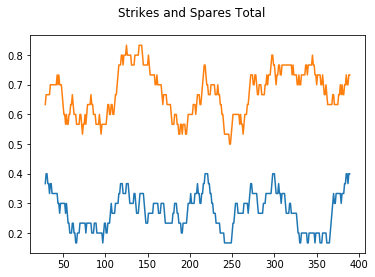

In [14]:
ax = pd.DataFrame({'Strike': rolling_strike, 'Spare': rolling_spare}).dropna().plot(
    stacked=True, legend=False)
ax.figure.suptitle('Strikes and Spares Total');

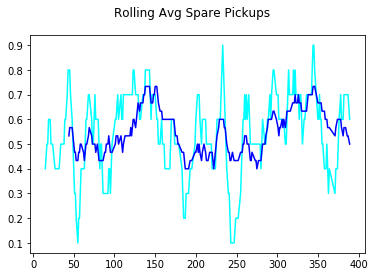

In [15]:
spare_leaves = frames_df[frames_df['T1'] < 10]
spare_pickups = (spare_leaves['T1'] + spare_leaves['T2'] == 10).astype(int)
ax = spare_pickups.rolling(10).mean().plot(color="cyan");
spare_pickups.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Spare Pickups');

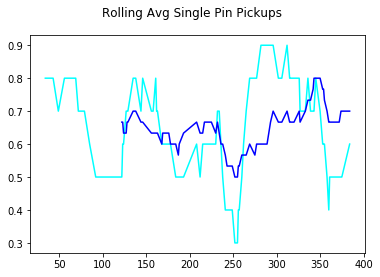

In [16]:
single_pin_leaves = frames_df[frames_df['T1'] == 9]
single_pin_spares = (single_pin_leaves['T2'] == 1).astype(int)
ax = single_pin_spares.rolling(10).mean().plot(color="cyan");
single_pin_spares.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Single Pin Pickups');

In [17]:
def get_single_pin_leaves(pin_leaves, pin):
    for i, leave in enumerate(pin_leaves):
        if leave['first_ball'] == {pin}:
            yield i, leave

def get_makes(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 0:
            yield i
            
def get_misses(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 1:
            yield i

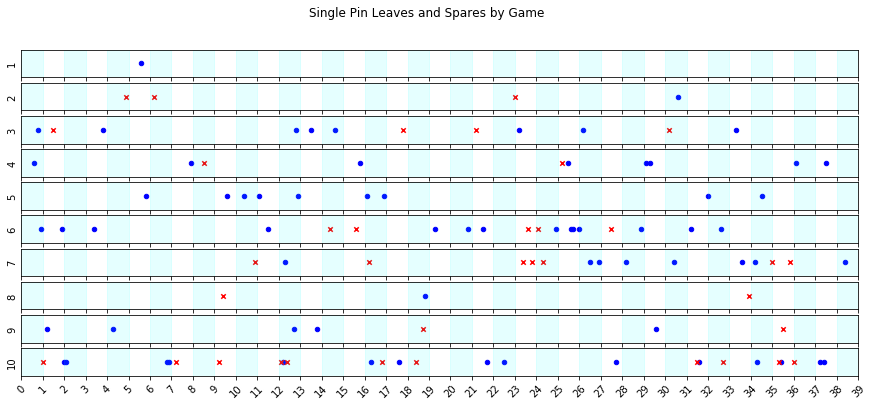

In [18]:
x = range(len(pin_leaves))
fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(15, 6))
for pin, ax in enumerate(axs, 1):
    makes = list(get_makes(pin_leaves, pin))
    ax.scatter(makes, [0]*len(makes), marker='o', color='b', s=20)
    misses = list(get_misses(pin_leaves, pin))
    ax.scatter(misses, [0]*len(misses), marker='x', color='r', s=20)
    ax.set_yticks([])
    ax.set_ylabel(pin)
    ax.set_xlim(0, len(pin_leaves))
    for i in range(0, len(pin_leaves), 20):
        ax.axvspan(i, i+10, color='cyan', alpha=.1)
ax.set_xticks(range(0, len(pin_leaves)+10, 10))
ax.set_xticklabels(range(0, int(len(pin_leaves)/10)+1));
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.suptitle('Single Pin Leaves and Spares by Game');